# An enquiry of poissons ratio for particle based structures

In this document I will mesh multiple different structures in order to asses the appearant Poisson's ratio that can appear in lattice materials.   

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import time

import sys, os

sys.path.append(os.path.abspath("../."))
sys.path.append(os.path.abspath("../.."))
from Particle_System_Simulator.particleSystem.ParticleSystem import ParticleSystem

matplotlib.rcParams["figure.figsize"] = [10, 5]
# %matplotlib qt

# dictionary of required parameters
params = {
    # model parameters
    "k": 1,  # [N/m]     spring stiffness
    "c": 1,  # [N s/m] damping coefficient
    "m_segment": 1,  # [kg] mass of each node
    # simulation settings
    "dt": 0.1,  # [s]       simulation timestep
    "t_steps": 1000,  # [-]      number of simulated time steps
    "abs_tol": 1e-50,  # [m/s]     absolute error tolerance iterative solver
    "rel_tol": 1e-5,  # [-]       relative error tolerance iterative solver
    "max_iter": 1e5,  # [-]       maximum number of iterations
    # physical parameters
    "g": 9.807,  # [m/s^2]   gravitational acceleration
}

## Meshing
Meshing is fully manual at the moment. This means it is up to us to define a clever discretization for the object we want to simulate. For this tutourial we will simulate a square with different lattice structures

In [3]:
# grid discretization
# We will use a rectanular grid of 20 x 20, which is 21 x 21 nodes spaced 1 unit apart
grid_width = 10
grid_length = 10

params["l0"] = 1
params["n"] = (grid_width + 1) * (grid_length + 1)

# Setting up the coordinates for the nodes
mesh = np.meshgrid(
    np.linspace(0, grid_length, grid_length + 1),
    np.linspace(0, grid_width, grid_width + 1),
)


# Fitting it into the required format and setting boundary conditions
# A the core of it this section converts the coordinate grids into a list of nodes
initial_conditions = []
xy_coordinates = np.column_stack(list(zip(mesh[0], mesh[1]))).T
xyz_coordinates = np.column_stack((xy_coordinates, np.zeros(len(xy_coordinates)).T))

for xyz in xyz_coordinates:
    fixed = False
    if (
        xyz[0] == 0 or xyz[0] == grid_length
    ):  # For fixing the other boundary use "xyz[1] == 0 or xyz[1] == grid_width"
        fixed = True
    initial_conditions.append([xyz, np.zeros(3), params["m_segment"], fixed])

# Setting up the connectivity matrix
connectivity_matrix = np.zeros((params["n"], params["n"]))
connections = []

# We know that all the nodes are connected to those of the next row, which is grid_length+1 units further
for i, node in enumerate(
    initial_conditions[: -grid_length - 1]
):  # adding connextions in y-axis
    connections.append([i, i + grid_length + 1, params["k"], params["c"]])

    if (i + 1) % (grid_length + 1):
        connections.append([i, i + grid_length + 2, params["k"], params["c"]])
        connections.append([i + 1, i + grid_length + 1, params["k"], params["c"]])

# We can do the same for the connections between the columns
for i, node in enumerate(initial_conditions):  # adding connections in x-axis
    if (i + 1) % (
        grid_length + 1
    ):  # Using modulus operator to exclude the nodes at the end of a row
        connections.append([i, i + 1, params["k"], params["c"]])

## Checking the mesh
Now that we have set up the mesh, we can check if all the nodes and connection are in the right place by plotting it. 

Text(0.5, 0.92, 'Initial state')

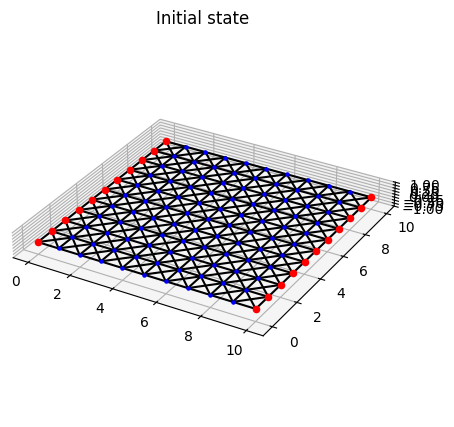

In [4]:
# Plotting mesh
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i, node in enumerate(initial_conditions):
    if node[3]:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="red", marker="o")
    else:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="blue", marker="o", s=5)

for connection in connections:
    line = np.column_stack(
        [initial_conditions[connection[0]][0], initial_conditions[connection[1]][0]]
    )

    ax.plot(line[0], line[1], line[2], color="black")

ax.set_box_aspect((grid_length, grid_width, 1))
ax.set_zlim(-1, 1)
plt.title("Initial state")

## Stressing the mesh
To stress the mesh we will move the points on the rightmost boundary in order to achieve a certain strain.

In [5]:
# Fist we have to setup the particle system and simulation
PS = ParticleSystem(connections, initial_conditions, params)
f_ext = np.array([[0, 0, 0] for i in range(params["n"])]).flatten()

t_vector = np.linspace(
    params["dt"], params["t_steps"] * params["dt"], params["t_steps"]
)
final_step = 0
E_kin = []
f_int = []

Text(0.5, 0.92, 'Initial state')

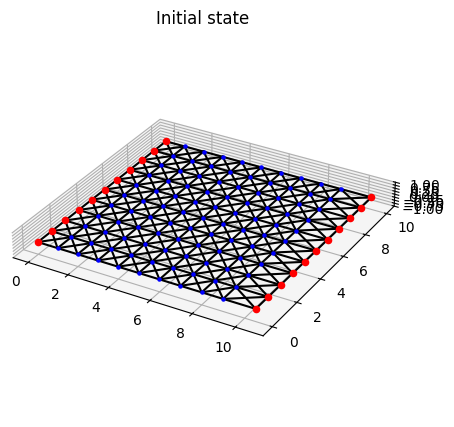

In [6]:
# Now we can move the nodes to stress the mesh

strain = 0.05

stressed_state = []
for node in PS.particles:
    if node.x[0] == grid_width:
        node.x[0] *= 1 + strain

    stressed_state.append([node.x, node.fixed])

# Plotting the strained mesh
fig = plt.figure()
ax = fig.add_subplot(projection="3d")


for i, node in enumerate(stressed_state):
    if node[1]:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="red", marker="o")
    else:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="blue", marker="o", s=5)

for connection in connections:
    line = np.column_stack(
        [stressed_state[connection[0]][0], stressed_state[connection[1]][0]]
    )

    ax.plot(line[0], line[1], line[2], color="black")

ax.set_box_aspect((grid_length, grid_width, 1))
ax.set_zlim(-1, 1)
plt.title("Initial state")

## Running the simulation
Now we will set up the simulation itself and run it. 

In [7]:
# And run the simulation
start_time = time.time()
for step in t_vector:
    PS.kin_damp_sim(f_ext)
    final_step = step
    (
        x,
        v,
    ) = PS.x_v_current

    E_kin.append(np.matmul(v, v))
    f_int.append(np.linalg.norm(PS.f_int))

    clear_output(wait=True)
    print("Step: {:.1F}, Kinetic Energy {:.2e}".format(step, E_kin[-1]))

    converged = False
    if step > 20 * params["dt"]:
        if np.max(E_kin[-10:-1]) <= 1e-20 * params["n"]:
            converged = True
    if converged and step > 1:
        print("Kinetic damping PS converged", step)
        break

stop_time = time.time()
print(f"PS: {(stop_time - start_time):.4f} s")

Step: 53.7, Kinetic Energy 5.62e-19
Kinetic damping PS converged 53.7
PS: 10.1791 s


Let's take a look at the convergence behaviour of the simulation and see what we can learn.

(0.1, 53.7)

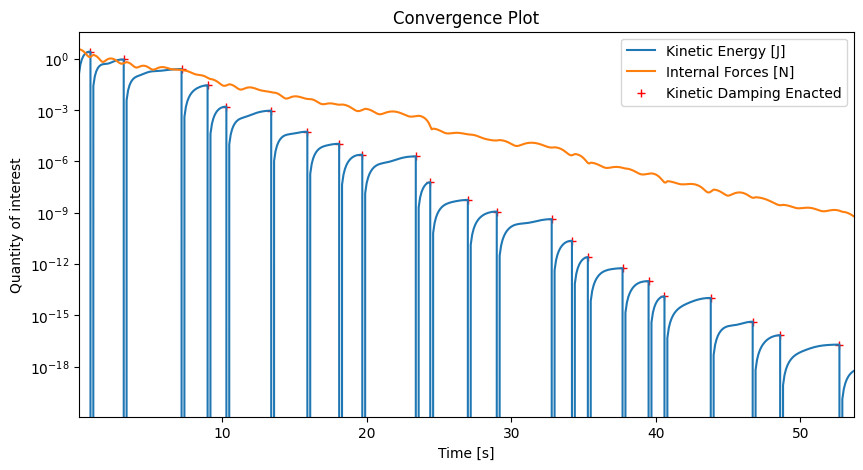

In [8]:
# Change these to zoom in on a specific region.
plotstop = len(E_kin)
plotstart = 0

plt.plot(t_vector[:plotstop], E_kin[:plotstop], label="Kinetic Energy [J]")
plt.plot(
    t_vector[plotstart:plotstop], f_int[plotstart:plotstop], label="Internal Forces [N]"
)

# Filtering out the peaks to mark where the kinetic damping algorithm kicked in.
df = pd.DataFrame(E_kin, index=t_vector[0:plotstop])
peaksonly = df[(df[0].shift(1) < df[0]) & (df[0].shift(-1) < df[0])]
plt.scatter(
    peaksonly.index,
    peaksonly[0],
    c="r",
    linewidths=1,
    marker="+",
    label="Kinetic Damping Enacted",
)

plt.legend()
plt.yscale("log")
plt.title("Convergence Plot")
plt.xlabel("Time [s]")
plt.ylabel("Quantity of interest")
plt.xlim(t_vector[0], t_vector[plotstop - 1])

## Reviewing results

To view the results we will once again plot the system in 3D. To do this we first have to extract the current positions from the system. After that we can re-use the code from the beginning to visualise our result. 

In [11]:
final_positions = [
    [particle.x, particle.v, particle.m, particle.fixed] for particle in PS.particles
]

# Plotting final results
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i, node in enumerate(final_positions):
    if node[3]:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="red", marker="o")
    else:
        ax.scatter(node[0][0], node[0][1], node[0][2], color="blue", marker="o", s=5)

for connection in connections:
    line = np.column_stack(
        [final_positions[connection[0]][0], final_positions[connection[1]][0]]
    )

    ax.plot(line[0], line[1], line[2], color="black")

ax.legend(["Fixed nodes", "Free nodes"])

# Finding bounding box and setting aspect ratio
xyz = np.array([particle.x for particle in PS.particles])
bb = [np.ptp(i) for i in xyz.T]
ax.set_box_aspect(bb)

plt.title("Final state")

Text(0.5, 0.92, 'Final state')

Error in callback <function _draw_all_if_interactive at 0x7f383c8d4b80> (for post_execute), with arguments args (),kwargs {}:


LinAlgError: Singular matrix

LinAlgError: Singular matrix

<Figure size 1000x500 with 1 Axes>

# Extracting Poisson's Ratio

Longitudinal strain 0.050, Transverse strain: -0.024, Poisson's ratio: 0.48


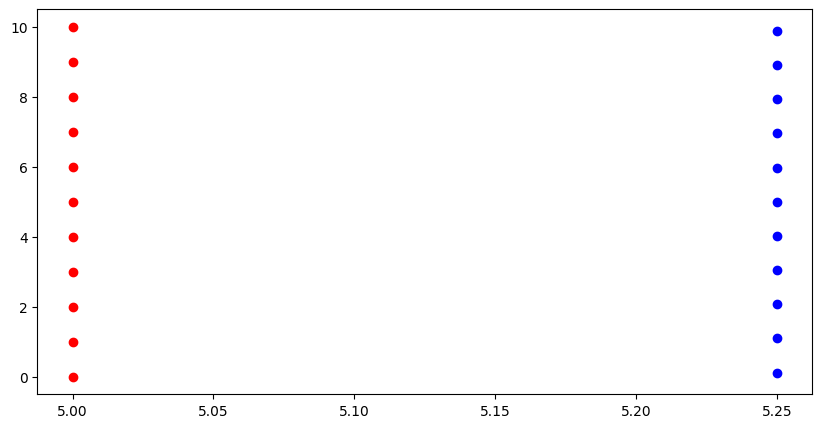

In [10]:
# Selecting central nodes
centre_set = final_positions[int(grid_width / 2) :: grid_length + 1]
centre_set_initial = initial_conditions[int(grid_width / 2) :: grid_length + 1]

xyz_coordinates_final = []

# Checking if I've done it right
fig3 = plt.figure()
ax3 = fig3.add_subplot()
for i, node in enumerate(centre_set):
    ax3.scatter(node[0][0], node[0][1], color="b", marker="o")
    ax3.scatter(
        centre_set_initial[i][0][0], centre_set_initial[i][0][1], color="r", marker="o"
    )
    xyz_coordinates_final.append(node[0])

xyz_coordinates_final = np.array(xyz_coordinates_final)
new_width = np.ptp(xyz_coordinates_final[:, 1])

transverse_strain = (new_width - grid_width) / grid_width

poissons_ratio = -transverse_strain / strain

print(
    "Longitudinal strain {:.3F}, Transverse strain: {:.3F}, Poisson's ratio: {:.2F}".format(
        strain, transverse_strain, poissons_ratio
    )
)